# PhenomSourceCalculator

This example shows how to create a SASE pulse with a phenomenological model described in this paper by Trey Guest et al.: https://doi.org/10.1107/S2052252523008242

In [1]:
from SimExLite.SourceCalculators import PhenomSourceCalculator
import h5py as h5
from matplotlib import pyplot as plt
from wpg.wpg_uti_wf import get_intensity_on_axis
import numpy as np

In [2]:
def analytical_pulse_width(photon_energy):
    """
    Estimate analytical_pulse_width (FWHM) from radiation energy (assumes symmetrical beam)

    :param photon_energy: radiation energy [eV]

    :return sig: Radiation pulse width [m]
    """

    sig = np.log((7.4e03/(photon_energy/1e03)))*6
    return sig/1e6


def analytical_pulse_divergence(photon_energy):
    
    """
    Estimate of analytical_pulse_divergence (half-angle) from radiation energy

    :param photon_energy: radiation energy [eV]

    :return dtheta: pulse divergence [rad]
    """
    return ((14.1)/((photon_energy/1e03)**0.75)) / 1e06

## Construct Calculator

In [3]:
psc = PhenomSourceCalculator("psc",)
psc.parameters['spectral_bandwidth'] = 1e-12
psc.parameters

 - Parameters object -
range_x                             [-0.0002  0.0002] [meter]              The spacial mesh range in x direction. [start, end]   
num_x                               512                             Number of mesh points in x direction.   
range_y                             [-0.0002  0.0002] [meter]              The spacial mesh range in y direction. [start, end]   
num_y                               512                             Number of mesh points in y direction.   
range_t                             [-2.5e-14  2.5e-14] [second]             The temporal range. [start, end]   
num_t                               250                             Number of mesh points in t direction.   
photon_energy                       10000.0    [electron_volt]      The photon energy of X-ray beam.   
pulse_energy                        0.0001     [joule]              Total energy of the pulse   
pulse_duration                      1.5e-14    [second]             The leng

In [4]:
# Set pulse width and pulse divergence according to photon_energy
psc.parameters["sigma"] = analytical_pulse_width(psc.parameters["photon_energy"].value)
psc.parameters["div"] = analytical_pulse_divergence(psc.parameters["photon_energy"].value)
psc.parameters

 - Parameters object -
range_x                             [-0.0002  0.0002] [meter]              The spacial mesh range in x direction. [start, end]   
num_x                               512                             Number of mesh points in x direction.   
range_y                             [-0.0002  0.0002] [meter]              The spacial mesh range in y direction. [start, end]   
num_y                               512                             Number of mesh points in y direction.   
range_t                             [-2.5e-14  2.5e-14] [second]             The temporal range. [start, end]   
num_t                               250                             Number of mesh points in t direction.   
photon_energy                       10000.0    [electron_volt]      The photon energy of X-ray beam.   
pulse_energy                        0.0001     [joule]              Total energy of the pulse   
pulse_duration                      1.5e-14    [second]             The leng

In [5]:
output = psc.backengine()
print(output)

Data collection:
key - mapping

Phenom_wavefront - <class 'SimExLite.WavefrontData.WPGFormat.WPGFormat'>: PhenomSourceCalculator/wavefront.h5



## Get energy spectrum and temporal profile from the output

In [6]:
from wpg.wavefront import Wavefront
from wpg.wpg_uti_wf import plot_intensity_map,plot_t_wf, plot_wf, integral_intensity, get_intensity_on_axis
from wpg.srw import srwlpy

wfr = Wavefront()
wfr.load_hdf5(output["Phenom_wavefront"].filename)
# srwlpy.SetRepresElecField(wfr._srwl_wf, 'time')

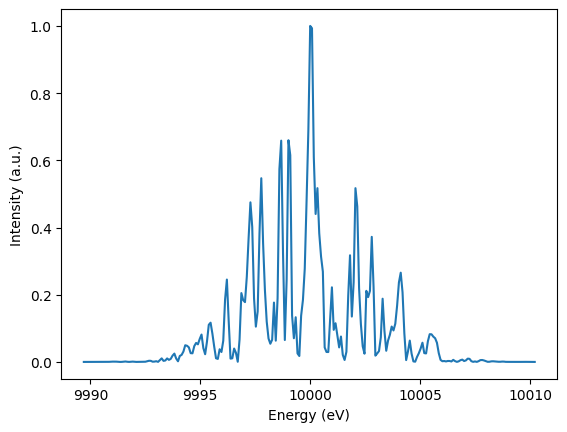

In [7]:
# Intensity in frequency domain
srwlpy.SetRepresElecField(wfr._srwl_wf, 'frequency')
data = get_intensity_on_axis(wfr)
fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1])
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Intensity (a.u.)")

fname = "spectrum.txt"
np.savetxt(fname, data, header = "energy(eV)  intensity")

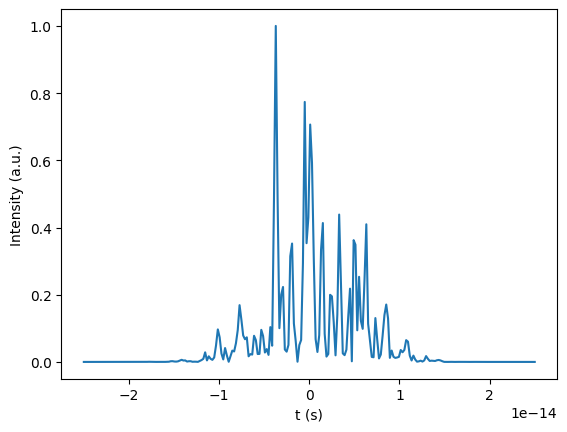

In [8]:
# Intensity in time domain
srwlpy.SetRepresElecField(wfr._srwl_wf, 'time')
[t, intensity] = get_intensity_on_axis(wfr).T
data = get_intensity_on_axis(wfr)
after_shift = np.fft.fftshift(data[:,1])

fig, ax = plt.subplots()
ax.plot(data[:,0], after_shift)
ax.set_xlabel("t (s)")
ax.set_ylabel("Intensity (a.u.)")

fname = "I_t.txt"
np.savetxt(fname, np.vstack([data[:,0], after_shift]).T, header = "t(s)  intensity")